In [ ]:
!unzip /content/daphnet+freezing+of+gait.zip -d dataset

Archive:  /content/daphnet+freezing+of+gait.zip
   creating: dataset/dataset_fog_release/
   creating: dataset/dataset_fog_release/dataset/
  inflating: dataset/dataset_fog_release/dataset/S01R01.txt  
  inflating: dataset/dataset_fog_release/dataset/S01R02.txt  
  inflating: dataset/dataset_fog_release/dataset/S02R01.txt  
  inflating: dataset/dataset_fog_release/dataset/S02R02.txt  
  inflating: dataset/dataset_fog_release/dataset/S03R01.txt  
  inflating: dataset/dataset_fog_release/dataset/S03R02.txt  
  inflating: dataset/dataset_fog_release/dataset/S03R03.txt  
  inflating: dataset/dataset_fog_release/dataset/S04R01.txt  
  inflating: dataset/dataset_fog_release/dataset/S05R01.txt  
  inflating: dataset/dataset_fog_release/dataset/S05R02.txt  
  inflating: dataset/dataset_fog_release/dataset/S06R01.txt  
  inflating: dataset/dataset_fog_release/dataset/S06R02.txt  
  inflating: dataset/dataset_fog_release/dataset/S07R01.txt  
  inflating: dataset/dataset_fog_release/dataset/S07R0

Visualizing x,y,z accelerations o ankle, thigh and waist for person 1

/tmp/ipython-input-2963434338.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, delim_whitespace=True, names=col_names)


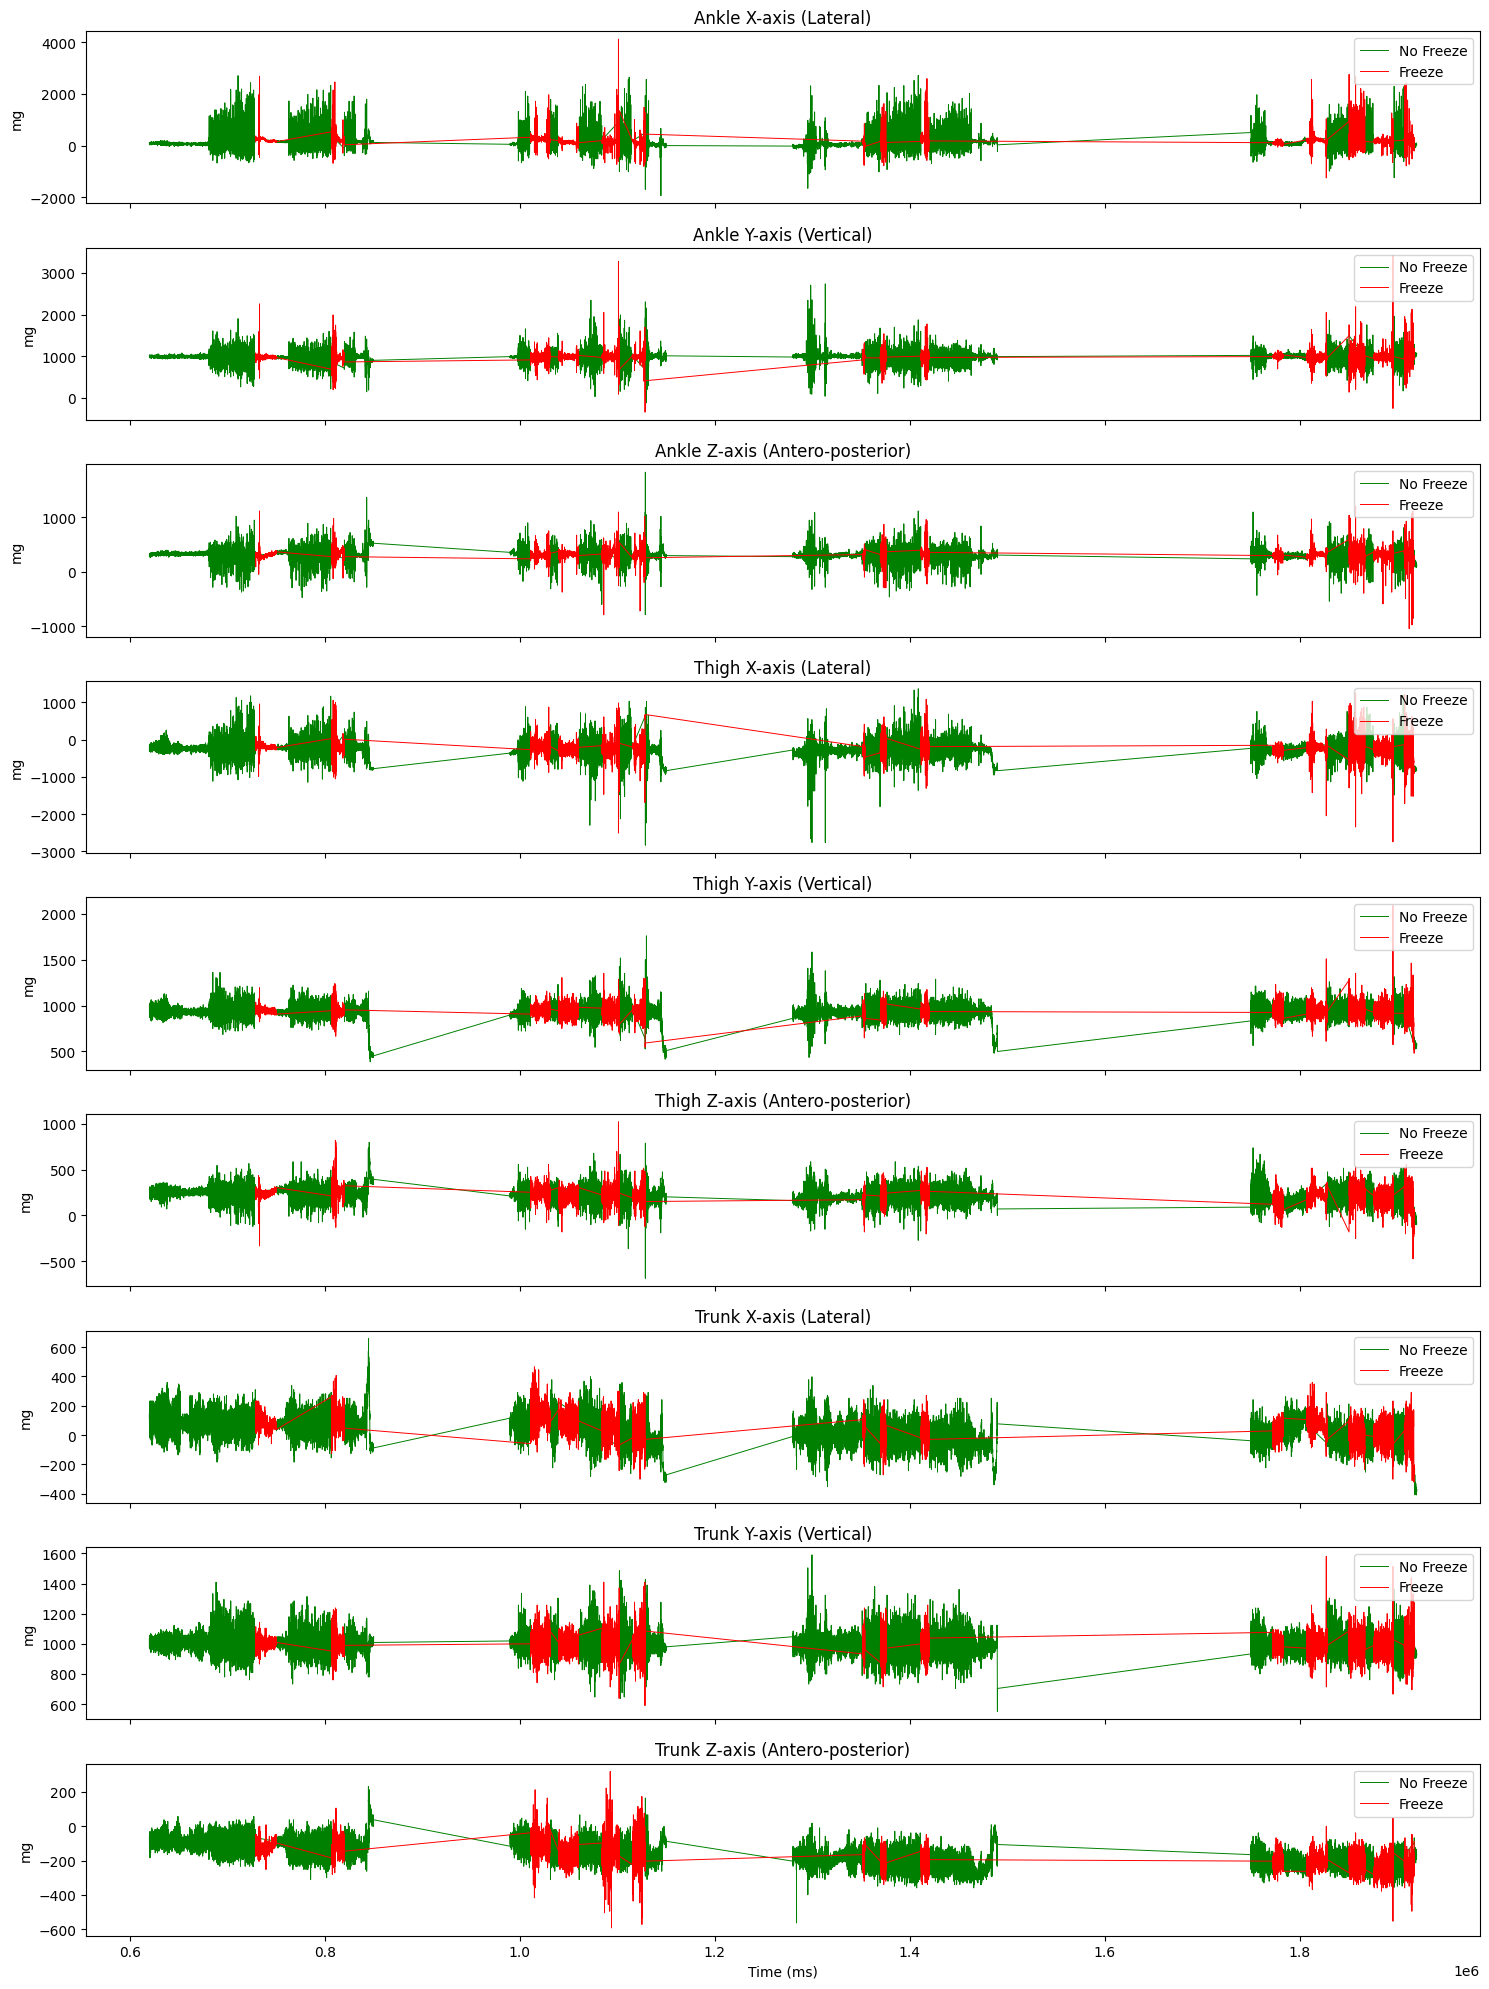

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
filepath = "/content/dataset/dataset_fog_release/dataset/S08R01.txt"
col_names = [
    "Time",
    "Ankle_Acc_X", "Ankle_Acc_Y", "Ankle_Acc_Z",
    "Thigh_Acc_X", "Thigh_Acc_Y", "Thigh_Acc_Z",
    "Trunk_Acc_X", "Trunk_Acc_Y", "Trunk_Acc_Z",
    "Annotation"
]
df = pd.read_csv(filepath, delim_whitespace=True, names=col_names)

# Filter only rows with Annotation != 0
df_exp = df[df['Annotation'] != 0]

# Creating 9 subplots (3 axes per body part)
fig, axs = plt.subplots(9, 1, figsize=(15, 20), sharex=True)

# Define colors
colors = {1: 'green', 2: 'red'}

# Axis labels and titles
axes = [
    'Ankle_Acc_X', 'Ankle_Acc_Y', 'Ankle_Acc_Z',
    'Thigh_Acc_X', 'Thigh_Acc_Y', 'Thigh_Acc_Z',
    'Trunk_Acc_X', 'Trunk_Acc_Y', 'Trunk_Acc_Z'
]
titles = [
    'Ankle X-axis (Lateral)', 'Ankle Y-axis (Vertical)', 'Ankle Z-axis (Antero-posterior)',
    'Thigh X-axis (Lateral)', 'Thigh Y-axis (Vertical)', 'Thigh Z-axis (Antero-posterior)',
    'Trunk X-axis (Lateral)', 'Trunk Y-axis (Vertical)', 'Trunk Z-axis (Antero-posterior)'
]

# Plotting loop
for i, (axis, title) in enumerate(zip(axes, titles)):
    for annotation in [1, 2]:  # 1: No Freeze, 2: Freeze
        segment = df_exp[df_exp['Annotation'] == annotation]
        axs[i].plot(segment['Time'], segment[axis],
                    label='Freeze' if annotation == 2 else 'No Freeze',
                    color=colors[annotation], linewidth=0.7)
    axs[i].set_ylabel('mg')
    axs[i].set_title(title)
    axs[i].legend(loc='upper right')

# Common X label
axs[-1].set_xlabel('Time (ms)')

plt.tight_layout()
plt.show()


Visualizing points of ankle vertical acceleration clearly in between 1 and 1.4 ms

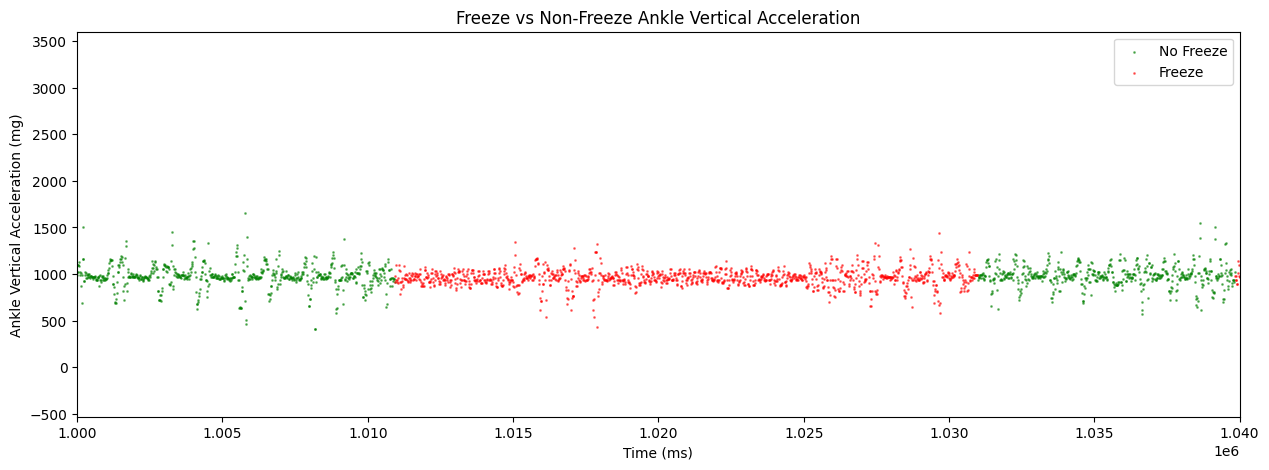

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# df_exp is filtered DataFrame (annotation != 0)

plt.figure(figsize=(15,5))

# Plot no-freeze points
no_freeze = df_exp[df_exp['Annotation'] == 1]
plt.scatter(no_freeze['Time'], no_freeze['Ankle_Acc_Y'], color='green', s=1, alpha=0.5, label='No Freeze')

# Plot freeze points
freeze = df_exp[df_exp['Annotation'] == 2]
plt.scatter(freeze['Time'], freeze['Ankle_Acc_Y'], color='red', s=1, alpha=0.5, label='Freeze')

plt.xlabel('Time (ms)')
plt.ylabel('Ankle Vertical Acceleration (mg)')
plt.title('Freeze vs Non-Freeze Ankle Vertical Acceleration')
plt.legend()

# Zoom in on a 20-second window
plt.xlim(1_000_000, 1_040_000)

plt.show()


In [110]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Path to the folder
folder_path = "/content/dataset/dataset_fog_release/dataset"

# Column names
col_names = ["Time",
    "Ankle_Acc_X", "Ankle_Acc_Y", "Ankle_Acc_Z",
    "Thigh_Acc_X", "Thigh_Acc_Y", "Thigh_Acc_Z",
    "Trunk_Acc_X", "Trunk_Acc_Y", "Trunk_Acc_Z",
    "Annotation"]

# Feature extraction function
def extract_features(df, window_size=200):
    features = []
    labels = []

    for i in range(0, len(df) - window_size, window_size):
        segment = df.iloc[i:i+window_size]
        feature_vector = []

        for col in df.columns[1:-1]:
            values = segment[col].values
            feature_vector.extend([
                np.mean(values),
                np.std(values),
                np.min(values),
                np.max(values),
                np.sqrt(np.mean(values**2)) #RMS
            ])

        label = segment["Annotation"].mode()[0]
        features.append(feature_vector)
        labels.append(label)

    return np.array(features), np.array(labels)

# Empty lists to hold data
X_all = []
y_all = []

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
        filepath = os.path.join(folder_path, filename)
        df = pd.read_csv(filepath, delim_whitespace=True, names=col_names)

        # Filter only annotated experiment data
        df_exp = df[df["Annotation"] != 0].reset_index(drop=True)

        # Skip files with very few annotations
        if len(df_exp) < 200:
            continue

        # Extract features and labels
        X, y = extract_features(df_exp)

        # Append to overall dataset
        X_all.append(X)
        y_all.append(y)

# Combine data from all subjects
X = np.vstack(X_all)
y = np.concatenate(y_all)

print("Final dataset shape:", X.shape, y.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["No FoG", "FoG"]))


/tmp/ipython-input-2182585154.py:52: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, delim_whitespace=True, names=col_names)
/tmp/ipython-input-2182585154.py:52: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, delim_whitespace=True, names=col_names)
/tmp/ipython-input-2182585154.py:52: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, delim_whitespace=True, names=col_names)
/tmp/ipython-input-2182585154.py:52: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, delim_whitespace=True, names=col_names)
/tmp/ipy

Final dataset shape: (5698, 45) (5698,)
              precision    recall  f1-score   support

      No FoG       0.94      0.98      0.96      1031
         FoG       0.71      0.36      0.48       109

    accuracy                           0.92      1140
   macro avg       0.82      0.67      0.72      1140
weighted avg       0.91      0.92      0.91      1140



In [134]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
smote = SMOTE()
over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# X, y = pipeline.fit_resample(X, y)
X_resampled, y_resampled = pipeline.fit_resample(X, y)
# X_resampled, y_resampled = X, y
# Reshape back
X_resampled = X_resampled.reshape((X_resampled.shape[0], X_resampled.shape[1], 1))

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled.reshape(-1, X_resampled.shape[-1])).reshape(X_resampled.shape)
# Train-test split (no to_categorical!)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

In [135]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Model
model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(128, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(256, kernel_size=3, activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling1D(),

    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.5085 - loss: 2.3418e-04 - val_accuracy: 0.6744 - val_loss: -0.9369
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6715 - loss: -3.9159 - val_accuracy: 0.6744 - val_loss: -3.2109
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6687 - loss: -9.9363 - val_accuracy: 0.6744 - val_loss: -7.9641
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6636 - loss: -18.9302 - val_accuracy: 0.6744 - val_loss: -18.6521
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6812 - loss: -30.5190 - val_accuracy: 0.6744 - val_loss: -40.1942
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6614 - loss: -48.4969 - val_accuracy: 0.6744 - val_loss: -60.1955
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6701 - loss: -65.9120 - val_accuracy: 0.6744 - val_loss: -84.3023
Epoch 8/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6690 - loss: -90

In [136]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6729 - loss: -5647.4902
Test Accuracy: 0.67


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


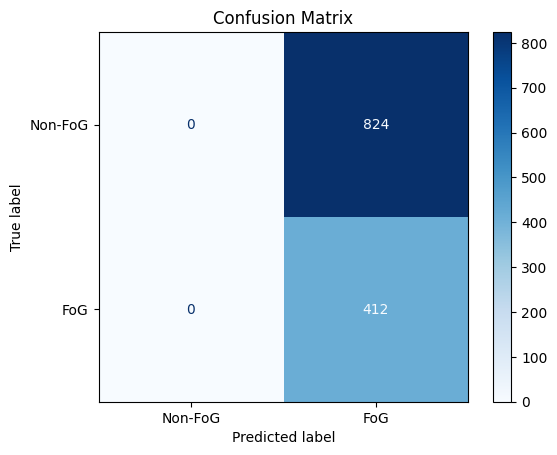

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten() + 1

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-FoG', 'FoG'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


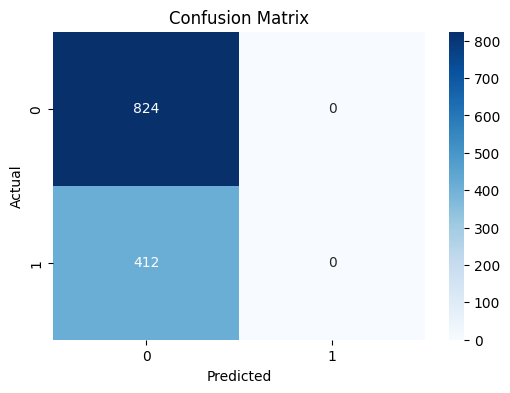

              precision    recall  f1-score   support

           1       0.67      1.00      0.80       824
           2       0.00      0.00      0.00       412

    accuracy                           0.67      1236
   macro avg       0.33      0.50      0.40      1236
weighted avg       0.44      0.67      0.53      1236



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [140]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred = model.predict(X_test)
# For binary classification with sigmoid output, threshold at 0.5
y_pred_classes = (y_pred > 0.5).astype(int).flatten()
y_true_classes = y_test # y_test is already 1-dimensional

cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Print metrics
print(classification_report(y_true_classes, y_pred_classes))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

NameError: name 'model' is not defined

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(X_scaled.shape[1], X_scaled.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Dropout(0.3),

    Conv1D(128, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(256, kernel_size=3, activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling1D(),

    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')  # Change units to 2 and activation to softmax for multi-class
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy']) # Change loss function
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)              │ (None, 41, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 41, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 16, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 16, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 6, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 6, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 174,978 (683.51 KB)

 Trainable params: 174,082 (680.01 KB)

 Non-trainable params: 896 (3.50 KB)